In [1]:
import json
from LangGraphAgent import LangGraphAgentWorkflow
from dotenv import load_dotenv
import os
# from langfuse import Langfuse
import openai
from openai import AzureOpenAI
from pydantic import BaseModel


In [2]:


load_dotenv()

# # financial scanner
client_chat = AzureOpenAI(
    azure_endpoint="https://data-ai-labs-poc.openai.azure.com/",
    api_key=os.getenv("AZURE2"),
    api_version="2024-08-01-preview"
)

# langfuse = Langfuse(
#   secret_key=os.getenv('LANGFUSE_SECRET_KEY'),
#   public_key=os.getenv('LANGFUSE_PUBLIC_KEY'),
#   host=os.getenv('LANGFUSE_HOST')
# )

chat_deployment = "docs-dev-struct-4o"



In [3]:
class ResponseSO(BaseModel):
    ingredients: str
    url: str 
    explanation: str
    
generator_prompt = f'''
    You are a product scanner.
'''

input_text = f'''
    What's in the ingredients for Chex Honey Nut Gluten Free Cereal in the US? 
    - Use your TavilySearchResults() tool and scrape information directly off of urls. 
    - Once the answer has been provided, don't use your tool and route to the "formatter_agent" agent. 
'''


input_dict = {
        "generator_pydantic_class":ResponseSO,
        "generator_prompt":generator_prompt,
        "input_text": input_text
}
agent = LangGraphAgentWorkflow(input_dict)

# Orchestration

In [4]:
agent.load_environment_variables()
tools = agent.create_tool()
model = agent.initialize_model(tools)
app = agent.create_workflow(agent.should_continue, agent.call_model)
final_output = agent.run_agent(app)

INFO:LangGraphAgent:Agent received messages: ['\n    You are a product scanner.\n\n\n', '\n    What\'s in the ingredients for Chex Honey Nut Gluten Free Cereal in the US? \n    - Use your TavilySearchResults() tool and scrape information directly off of urls. \n    - Once the answer has been provided, don\'t use your tool and route to the "formatter_agent" agent. \n']


INFO:httpx:HTTP Request: POST https://data-ai-labs-poc.openai.azure.com/openai/deployments/docs-dev-struct-4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"
INFO:LangGraphAgent:Agent response: content='' additional_kwargs={'tool_calls': [{'id': 'call_ITVcoOljrgFIclxFA0WR3pvv', 'function': {'arguments': '{"query":"Chex Honey Nut Gluten Free Cereal ingredients"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 198, 'total_tokens': 224, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f3927aa00d', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 

agent


ValueError: Last message is not an AIMessage

In [5]:
final_output = json.loads(agent.final_response.model_dump_json())
final_output

{'ingredients': 'Whole Grain Corn, Sugar, Corn Meal, Honey, Brown Sugar Syrup, Salt, Baking Soda, Natural Flavor, Vitamin E (mixed tocopherols) added to preserve freshness.',
 'url': 'https://www.chex.com/products/honey-nut-chex/',
 'explanation': 'The ingredients for Chex Honey Nut Gluten Free Cereal include whole grain corn, sugar, corn meal, honey, brown sugar syrup, salt, baking soda, natural flavor, and vitamin E (mixed tocopherols) added to preserve freshness. This information was obtained from the official Chex website, ensuring accuracy and reliability.'}

In [9]:
agent.final_state['messages'][1].content

'content=\'\' additional_kwargs={\'tool_calls\': [{\'id\': \'call_f4QgnaTKgOYx8Jb2zTbC86v2\', \'function\': {\'arguments\': \'{"query":"Chex Honey Nut Gluten Free Cereal ingredients"}\', \'name\': \'tavily_search_results_json\'}, \'type\': \'function\'}], \'refusal\': None} response_metadata={\'token_usage\': {\'completion_tokens\': 26, \'prompt_tokens\': 198, \'total_tokens\': 224, \'completion_tokens_details\': {\'accepted_prediction_tokens\': 0, \'audio_tokens\': 0, \'reasoning_tokens\': 0, \'rejected_prediction_tokens\': 0}, \'prompt_tokens_details\': {\'audio_tokens\': 0, \'cached_tokens\': 0}}, \'model_name\': \'gpt-4o-2024-08-06\', \'system_fingerprint\': \'fp_f3927aa00d\', \'prompt_filter_results\': [{\'prompt_index\': 0, \'content_filter_results\': {\'hate\': {\'filtered\': False, \'severity\': \'safe\'}, \'self_harm\': {\'filtered\': False, \'severity\': \'safe\'}, \'sexual\': {\'filtered\': False, \'severity\': \'safe\'}, \'violence\': {\'filtered\': False, \'severity\': \'s

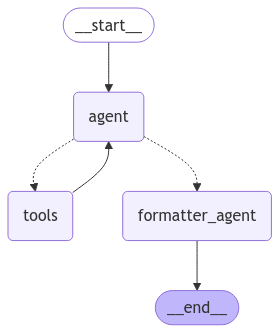

In [7]:
app

# New Type

In [10]:
from langfuse import Langfuse
from langfuse.callback import CallbackHandler

langfuse = Langfuse(
  secret_key="sk-lf-d379edfd-236f-4ae7-a6ce-c7e3aa34882d",
  public_key="pk-lf-18dd852a-7bf5-4253-825a-129afe1995bb",
  host="https://us.cloud.langfuse.com"
)

langfuse_handler = CallbackHandler(
    public_key="pk-lf-79d74889-b276-4824-86b7-8a6b945cc788",
    secret_key="sk-lf-c43a5d53-7ec9-4f12-b985-badf59a27376",
    host="https://us.cloud.langfuse.com"
)

In [21]:
from langchain_openai import AzureChatOpenAI
from pydantic import BaseModel, Field
from typing import Literal
from langchain_core.tools import tool
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage
from dotenv import load_dotenv
import os
from openai import AzureOpenAI
from pydantic import BaseModel

load_dotenv()

class WeatherResponse(BaseModel):
    """Respond to the user with this"""

    temperature: float = Field(description="The temperature in fahrenheit")
    wind_directon: str = Field(
        description="The direction of the wind in abbreviated form"
    )
    wind_speed: float = Field(description="The speed of the wind in km/h")


# Inherit 'messages' key from MessagesState, which is a list of chat messages
class AgentState(MessagesState):
    # Final structured response from the agent
    final_response: WeatherResponse




@tool
def get_weather(city: Literal["nyc", "sf"]):
    """Use this to get weather information."""
    if city == "nyc":
        return "It is cloudy in NYC, with 5 mph winds in the North-East direction and a temperature of 70 degrees"
    elif city == "sf":
        return "It is 75 degrees and sunny in SF, with 3 mph winds in the South-East direction"
    else:
        raise AssertionError("Unknown city")

tools = [get_weather]

# Initialize Model 

AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_DEPLOYMENT_NAME = os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME")

model = AzureChatOpenAI(
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    openai_api_version="2024-08-01-preview",
    openai_api_key=AZURE_OPENAI_API_KEY,
    deployment_name=AZURE_OPENAI_DEPLOYMENT_NAME,
    temperature=0.0,  # For deterministic output
).bind_tools(tools)


model_with_tools = model.bind_tools(tools)
model_with_structured_output = model.with_structured_output(WeatherResponse)


# Define the function that calls the model
def call_model(state: AgentState):
    response = model_with_tools.invoke(state["messages"])
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the function that responds to the user
def respond(state: AgentState):
    # We call the model with structured output in order to return the same format to the user every time
    # state['messages'][-2] is the last ToolMessage in the convo, which we convert to a HumanMessage for the model to use
    # We could also pass the entire chat history, but this saves tokens since all we care to structure is the output of the tool
    response = model_with_structured_output.invoke(
        [HumanMessage(content=state["messages"][-2].content)]
    )
    # We return the final answer
    return {"final_response": response}


# Define the function that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we respond to the user
    if not last_message.tool_calls:
        return "respond"
    # Otherwise if there is, we continue
    else:
        return "continue"

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("respond", respond)
workflow.add_node("tools", ToolNode(tools))

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "respond": "respond",
    },
)

workflow.add_edge("tools", "agent")
workflow.add_edge("respond", END)

graph = workflow.compile()

answer = graph.invoke(input={"messages": [("human", "what's the weather in SF?")]},config={"callbacks": [langfuse_handler]})




In [23]:
answer['messages']

[HumanMessage(content="what's the weather in SF?", additional_kwargs={}, response_metadata={}, id='cc14af01-5ad0-4888-9489-e63848c6be09'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_75iUA660Pho04X666cveKiip', 'function': {'arguments': '{"city":"sf"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 58, 'total_tokens': 72, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f3927aa00d', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe

In [12]:
pip install pandas

  Using cached pandas-2.2.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.1 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.8/346.8 kB 8.0 MB/s eta 0:00:0000:01
  Using cached pytz-2024.2-py2.py3-none-any.whl (508 kB)

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
from LangGraphAgent import LangGraphAgentSystem
from langchain_openai import AzureChatOpenAI
from pydantic import BaseModel, Field
from typing import Literal
from langchain_core.tools import tool
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from dotenv import load_dotenv
import os
from openai import AzureOpenAI
from pydantic import BaseModel
from langfuse import Langfuse
from langfuse.callback import CallbackHandler
from pydantic import BaseModel, Field
import pandas as pd

In [2]:


class WeatherResponse(BaseModel):
    """Respond to the user with this"""
    temperature: float = Field(description="The temperature in fahrenheit")
    wind_directon: str = Field(
        description="The direction of the wind in abbreviated form"
    )
    wind_speed: float = Field(description="The speed of the wind in km/h")


class AgentState(MessagesState):
    # Final structured response from the agent
    final_response: WeatherResponse

def get_weather(city: Literal["nyc", "sf"]):
    """Use this to get weather information."""
    if city == "nyc":
        return "It is cloudy in NYC, with 5 mph winds in the North-East direction and a temperature of 70 degrees"
    elif city == "sf":
        return "It is 75 degrees and sunny in SF, with 3 mph winds in the South-East direction"
    else:
        raise AssertionError("Unknown city")
            
input_dict = {
    "input_prompt":"what's the weather in SF?",
    "agent_prompt":"You are a helpful assistant! Your name is Bob.",
    "agent_state":AgentState,
    "structured_output_class":WeatherResponse
}


# override create tools with a custom tooling.. 
class MyLG(LangGraphAgentSystem):
    def create_tools(lg):
        @tool
        def get_weather(city: Literal["nyc", "sf"]):
            """Use this to get weather information."""
            if city == "nyc":
                return "It is cloudy in NYC, with 1000 mph winds in the North-East direction and a temperature of 70 degrees"
            elif city == "sf":
                return "It is 75 degrees and sunny in SF, with 1000 mph winds in the South-East direction"
            else:
                raise AssertionError("Unknown city")

        tools = [get_weather]
        lg.tools = tools

lg = MyLG(input_dict)

answer = lg.run()

In [3]:
answer

{'messages': [HumanMessage(content="what's the weather in SF?", additional_kwargs={}, response_metadata={}, id='4fe61165-54a2-4770-955b-aff57be782c2'),
  SystemMessage(content='You are a helpful assistant! Your name is Bob.', additional_kwargs={}, response_metadata={}, id='a667cdab-168f-44a3-be3c-75f2ed49ea4e'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_T4uvUOAtYgkdmpZ4K8SEpecw', 'function': {'arguments': '{"city":"sf"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 73, 'total_tokens': 87, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f3927aa00d', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False,

In [4]:
type(answer['messages'][-3]) == ToolMessage

True

# Generalization

In [1]:

class SugarClass(BaseModel):
    """Respond to the user with this"""
    ingredients: str = Field(description="The sugar amount of the product")
    explanation: str = Field(description="An explanation of your reasoning")


class AgentState(MessagesState):
    # Final structured response from the agent
    final_response: SugarClass


input_dict = {
    "input_prompt":"what's the sugar content in okanaya? don't use your tool",
    "agent_prompt":"You are a helpful assistant! Your name is Bob.",
    "agent_state":AgentState,
    "structured_output_class":SugarClass
}


# override create tools with a custom tooling.. 
class MyLG(LangGraphAgentSystem):
    def create_tools(lg):
        @tool
        def get_sugar(product: Literal["okanaya", "cabaya"]):
            """Use this to get weather information."""
            if product == "cabaya":
                return "There is 1000 g of sugar in cabaya."
            elif product == "okanaya":
                return "There is 1g of sugar in okanaya "
            else:
                raise AssertionError("Unknown city")

        tools = [get_sugar]
        lg.tools = tools

lg = MyLG(input_dict)

answer = lg.run()



NameError: name 'BaseModel' is not defined

In [3]:
answer

{'messages': [HumanMessage(content="what's the sugar content in okanaya? don't use your tool", additional_kwargs={}, response_metadata={}, id='baedae70-5b19-480b-b621-43cff3e228b4'),
  SystemMessage(content='You are a helpful assistant! Your name is Bob.', additional_kwargs={}, response_metadata={}, id='8832aa06-ed16-4522-baeb-ce850a1f3552'),
  AIMessage(content="I'm unable to provide the sugar content in Okanaya without using the tool. Would you like me to use the tool to find this information for you?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 82, 'total_tokens': 114, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f3927aa00d', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results'